## double exponential Model, d-optimal

In [41]:
using Plots
using LinearAlgebra

# projection function onto the design space
function proj(x, design)
    n = Int((length(x)+1)/2)
    a = x[1:n]
    b = x[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    
    a = max.(a,design[1])
    a = min.(a,design[2])
    
    u = sort(b, rev=true)
    j = n
    while true
        if u[j] + 1/j*(1-cumsum(u)[j]) > 0
            break
        end
        j -= 1
    end
    lambda = 1/j*(1-cumsum(u)[j])
    b = max.(b .+ lambda,0)
    b = b[1:(n-1)]
    
    return [a;b]
end

proj (generic function with 1 method)

In [42]:
#Information matrix for quadratic logistic model
function infmat(x)
    n = Int((length(x)+1)/2)
    a = x[1:n]
    b = x[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    p = length(theta)+1
    mat = zeros(p,p)
    for i in 1:n
        c = theta[1]*exp(theta[2]*a[i]) + (1-theta[1])*exp(-theta[3]*a[i])
        f = [1; (exp(theta[2]*a[i]) - exp(-theta[3]*a[i]))/c; theta[1]*a[i]*exp(theta[2]*a[i])/c; -(1-theta[1])*a[i]*exp(-theta[3]*a[i])/c]
        mat = mat + b[i] * f*f'
    end
    return mat
end

infmat (generic function with 1 method)

In [43]:
function diter()
    #initialize
    #srand(1992)
    path = zeros(niter)
    tau = 0.9:(-0.5/niter):0.4
    v = zeros(nptc, 2k-1)
    x = (design[2]-design[1])*rand(nptc*k) .+ design[1]
    x = reshape(x,nptc,k)
    w = rand(nptc*(k-1))
    w = reshape(w,nptc,k-1)
    ptc = hcat(x,w)
    for j in 1:nptc
        ptc[j,:] = proj(ptc[j,:],design)
    end
    pbest = ptc
    pbesth = zeros(nptc)
    for i in 1:nptc
        pbesth[i] = det(infmat(pbest[i,:]))
    end
    gbesth = findmax(pbesth)[1]
    gbest = pbest[findmax(pbesth)[2],:]

    #iterate
    t1 = time_ns()
    for i in 1:niter # iteration number
        for j in 1:nptc # particle number
            v[j,:] = tau[i] .*v[j,:] + 2 .*rand(2k-1) .*(pbest[j,:]-ptc[j,:]) + 2 .*rand(2k-1) .*(gbest-ptc[j,:])
            ptc[j,:] = ptc[j,:] + v[j,:]
            ptc[j,:] = proj(ptc[j,:],design)
            fit = det(infmat(ptc[j,:]))
            if fit > gbesth
                gbest = pbest[j,:] = ptc[j,:]
                gbesth = pbesth[j] = fit
            elseif fit > pbesth[j]
                pbest[j,:] = ptc[j,:]
                pbesth[j] = fit
            end
        end
        path[i] = gbesth
    end
    t2 = time_ns()
    supp = gbest[1:k]
    prob = gbest[(k+1):2k-1]
    prob = [prob; 1-sum(prob)]
    plt = plot(1:niter, path)
    cput = (t2-t1)/10^9
    return [supp, prob, cput, path[niter], path[niter] - path[niter-Int(0.1*niter)], plot]
end

diter (generic function with 1 method)

In [4]:
theta = [.2; .2; .2]
design = [0,10]
k = 4
nptc = 100
niter = 100

t1 = time()
res = diter()
t2 = time()

1.577290737573302e9

In [5]:
res[1]

4-element Array{Float64,1}:
  2.659928057250068
  0.0              
 10.0              
  6.707400983959512

In [6]:
res[2]

4-element Array{Float64,1}:
 0.2499997759970329 
 0.25000090230404126
 0.2500002686885364 
 0.24999905301038938

In [7]:
t2-t1

24.146055936813354

In [19]:
repx = zeros(10^3,4)
repw = zeros(10^3,4)
fopt = zeros(10^3)

for rep in 1:10^3
    result = diter()
    repx[rep,:] = result[1]
    repw[rep,:] = result[2]
    fopt[rep] = result[4]
    print(rep)
end


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

In [40]:
1 - 0.17658726062898591/0.17658726080206524

9.80134862160753e-10

In [20]:
perm = sortperm(fopt)

repx = repx[perm,:]
repw = repw[perm,:]
fopt = fopt[perm] .^ (1/4)

1000-element Array{Float64,1}:
 0.17658726062898591
 0.1765872607218    
 0.1765872607269139 
 0.17658726073711997
 0.1765872607478908 
 0.17658726075010553
 0.17658726075250752
 0.1765872607628067 
 0.1765872607649868 
 0.17658726076581888
 0.17658726076752146
 0.17658726076849857
 0.1765872607694265 
 ⋮                  
 0.17658726080194254
 0.17658726080195758
 0.17658726080198156
 0.17658726080198833
 0.17658726080199016
 0.176587260801998  
 0.17658726080199919
 0.17658726080200068
 0.1765872608020041 
 0.17658726080201267
 0.17658726080206227
 0.17658726080206524

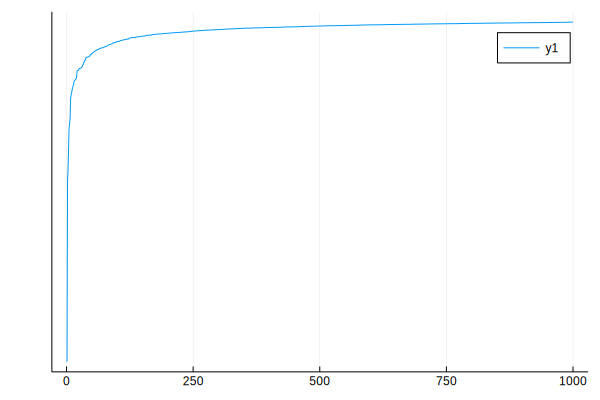

┌ Warning: No strict ticks found
└ @ PlotUtils /DATA/home/ppinsm/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /DATA/home/ppinsm/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /DATA/home/ppinsm/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /DATA/home/ppinsm/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168


In [21]:
plot(1:1000,fopt)

In [22]:
using StatsBase
countmap(round.(fopt,digits=6))

Dict{Float64,Int64} with 1 entry:
  0.176587 => 1000

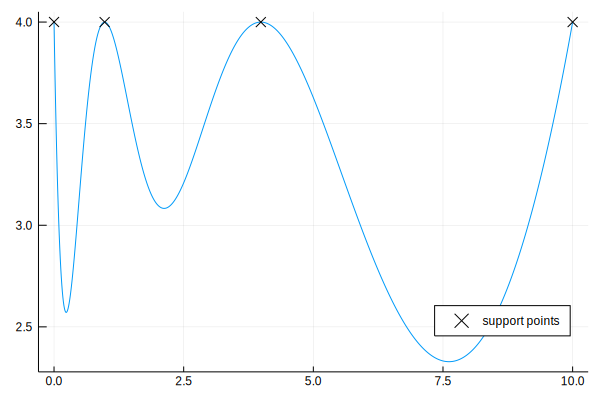

In [29]:
x = repx[1,:]
w = repw[1,:]

mat = zeros(4,4)
for i = 1:length(x)
    c = theta[1]*exp(theta[2]*x[i]) + (1-theta[1])*exp(-theta[3]*x[i])
    f = [1; (exp(theta[2]*x[i]) - exp(-theta[3]*x[i]))/c; theta[1]*x[i]*exp(theta[2]*x[i])/c; -(1-theta[1])*x[i]*exp(-theta[3]*x[i])/c]
    mat = mat + w[i] * f*f'
end
mati = inv(mat)

function equiv(x)
    c = theta[1]*exp(theta[2]*x) + (1-theta[1])*exp(-theta[3]*x)
    f = [1; (exp(theta[2]*x) - exp(-theta[3]*x))/c; theta[1]*x*exp(theta[2]*x)/c; -(1-theta[1])*x*exp(-theta[3]*x)/c]
    val = f'*mati*f
    return val
end

dp = design[1]:((design[2]-design[1])/1000):design[2]
plot(dp, equiv.(dp), label="")
scatter!(x,equiv.(x), markershape = :x, label="support points", legend = :bottomright)

In [30]:
theta = [.8; .5; .5]
design = [0,10]
k = 4
nptc = 100
niter =100

result = diter()

6-element Array{Any,1}:
  [10.0, 0.0, 0.97568, 3.98746]       
  [0.249998, 0.250002, 0.249999, 0.25]
 0.41406832                           
 0.0009723832731420183                
 5.0970089694041265e-12               
  RecipesBase.plot                    

In [31]:
result[1]

4-element Array{Float64,1}:
 10.0               
  0.0               
  0.9756796628876938
  3.9874555290530407

In [32]:
result[2]

4-element Array{Float64,1}:
 0.24999843634260377
 0.2500024700085415 
 0.24999894639857606
 0.25000014725027864

In [33]:
result[4]

0.0009723832731420183

In [34]:
repx = zeros(10^3,4)
repw = zeros(10^3,4)
fopt = zeros(10^3)

for rep in 1:10^3
    result = diter()
    repx[rep,:] = result[1]
    repw[rep,:] = result[2]
    fopt[rep] = result[4]
    print(rep)
end


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

In [35]:
perm = sortperm(fopt)

repx = repx[perm,:]
repw = repw[perm,:]
fopt = fopt[perm] .^ (1/4)

1000-element Array{Float64,1}:
 0.17658726067320474
 0.17658726071704217
 0.17658726072665576
 0.1765872607365041 
 0.1765872607387795 
 0.17658726073988554
 0.17658726074226713
 0.17658726074735956
 0.17658726074958114
 0.17658726075330725
 0.17658726075441097
 0.17658726075581505
 0.17658726076303766
 ⋮                  
 0.17658726080194911
 0.17658726080195125
 0.17658726080196   
 0.17658726080198123
 0.17658726080198497
 0.17658726080199963
 0.1765872608020111 
 0.17658726080202944
 0.1765872608020359 
 0.17658726080203635
 0.17658726080203918
 0.17658726080207485

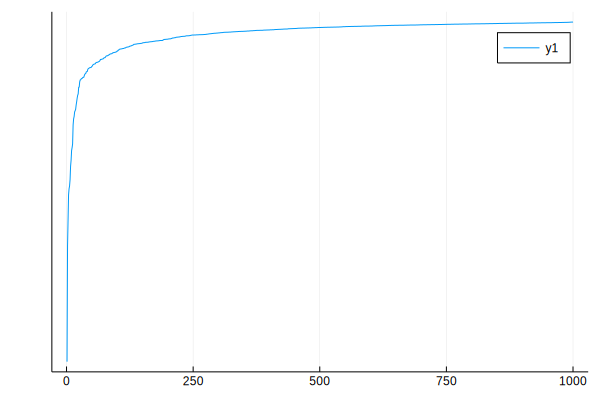

┌ Warning: No strict ticks found
└ @ PlotUtils /DATA/home/ppinsm/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /DATA/home/ppinsm/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /DATA/home/ppinsm/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /DATA/home/ppinsm/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168


In [36]:
plot(fopt)

In [37]:
using StatsBase
countmap(round.(fopt,digits=6))

Dict{Float64,Int64} with 1 entry:
  0.176587 => 1000

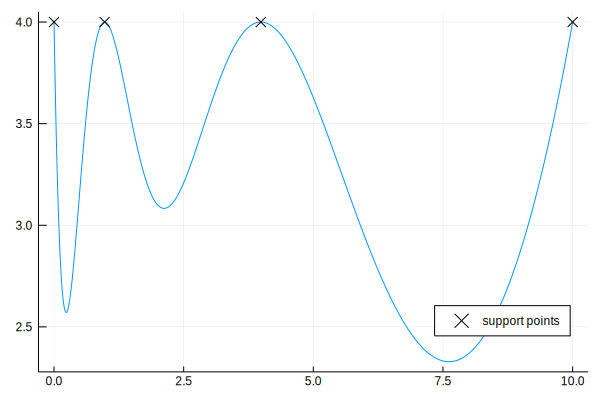

In [38]:
x = repx[1,:]
w = repw[1,:]

mat = zeros(4,4)
for i = 1:length(x)
    c = theta[1]*exp(theta[2]*x[i]) + (1-theta[1])*exp(-theta[3]*x[i])
    f = [1; (exp(theta[2]*x[i]) - exp(-theta[3]*x[i]))/c; theta[1]*x[i]*exp(theta[2]*x[i])/c; -(1-theta[1])*x[i]*exp(-theta[3]*x[i])/c]
    mat = mat + w[i] * f*f'
end
mati = inv(mat)

function equiv(x)
    c = theta[1]*exp(theta[2]*x) + (1-theta[1])*exp(-theta[3]*x)
    f = [1; (exp(theta[2]*x) - exp(-theta[3]*x))/c; theta[1]*x*exp(theta[2]*x)/c; -(1-theta[1])*x*exp(-theta[3]*x)/c]
    val = f'*mati*f
    return val
end

dp = design[1]:((design[2]-design[1])/1000):design[2]
plot(dp, equiv.(dp), label="")
scatter!(x,equiv.(x), markershape = :x, label="support points", legend = :bottomright)

In [70]:
theta = [.2; .2; .2]
design = [0,10]
k = 4
nptc = 100
niter = 100

res = diter()

6-element Array{Any,1}:
  [2.65994, 6.70741, 0.0, 10.0]   
  [0.25, 0.250001, 0.249999, 0.25]
 0.414711527                      
 0.16356828710256255              
 3.323030184354536e-10            
  RecipesBase.plot                

In [71]:
theta = [.2; .2; .2]
design = [0,10]
k = 5
nptc = 100
niter = 100

res = diter()

6-element Array{Any,1}:
  [10.0, 6.70741, 0.0, 2.65994, 0.0]                  
  [0.250001, 0.250001, 0.244607, 0.249998, 0.00539258]
 0.46082497                                           
 0.16356828709077223                                  
 4.5878853494052407e-10                               
  RecipesBase.plot                                    

In [72]:
theta = [.2; .2; .2]
design = [0,10]
k = 6
nptc = 100
niter = 100

res = diter()

6-element Array{Any,1}:
  [0.0, 6.70743, 10.0, 0.0, 0.0, 2.65993]                      
  [8.90701e-17, 0.249999, 0.250002, 0.25, 1.1419e-16, 0.249999]
 0.43557292                                                    
 0.16356828707580273                                           
 8.007737528625825e-10                                         
  RecipesBase.plot                                             

In [73]:
theta = [.2; .2; .2]
design = [0,10]
k = 7
nptc = 100
niter = 100

res = diter()

6-element Array{Any,1}:
  [6.70741, 10.0, 10.0, 2.65993, 10.0, 0.0, 0.0]           
  [0.25, 0.0, 0.0, 0.250001, 0.250001, 0.209127, 0.0408713]
 0.450599965                                               
 0.1635682871010714                                        
 6.306682620582649e-9                                      
  RecipesBase.plot                                         

In [85]:
fopt = zeros(100)
ft = zeros(100)

for i = 1:100
    global k = 4*i
    res = diter()
    fopt[i] = res[4]^(1/4)
    ft[i] = res[3]
end

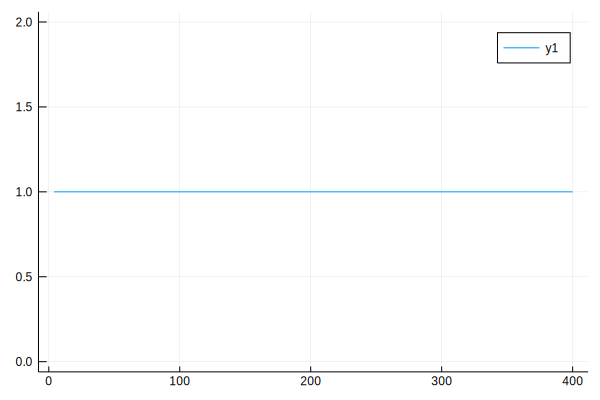

In [88]:
plot(4*(1:100), fopt ./ fopt[1],ylim = [0, 2] )

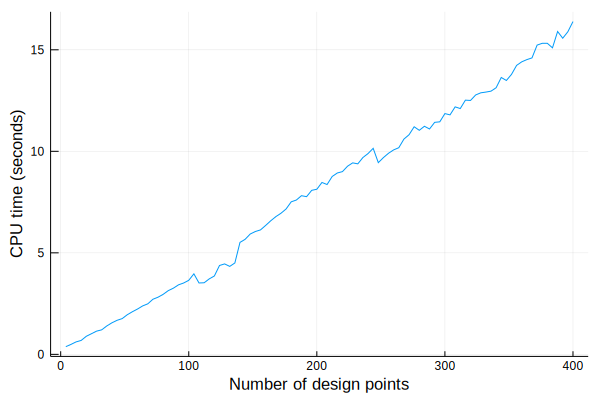

In [90]:
plot(4*(1:100), ft, label ="", xlab="Number of design points", ylab="CPU time (seconds)")